# <center>German apartment listings</center>

## 0) Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from timeit import default_timer as timer


import glob
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import dataprocessing as dproc

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

## 1) Data Processing

#### find dates:

In [2]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### load data:

In [3]:
rent_df = dproc.create_rent_df(dates[-1])
sale_df = dproc.create_sale_df(dates[-1])

<IPython.core.display.Javascript object>

#### add links:

In [4]:
rent_df["link"] = "https://www.immobilienscout24.de/expose/" + rent_df[
    "scoutId"
].astype(str)
sale_df["link"] = "https://www.immobilienscout24.de/expose/" + sale_df[
    "scoutId"
].astype(str)

<IPython.core.display.Javascript object>

#### select features:

In [5]:
rent_select_columns = [
    "rent_m2",
    "baseRent",
    "livingSpace",
    "noRooms",
    "zipCode",
    "regio2",
    "link",
]
rent_select_df = rent_df[rent_select_columns].copy()

sale_select_columns = [
    "price_m2",
    "purchasePrice",
    "livingSpace",
    "noRooms",
    "zipCode",
    "regio2",
    "link",
]
sale_select_df = sale_df[sale_select_columns].copy()

<IPython.core.display.Javascript object>

#### add return of investment based on median rents for zipCode

In [6]:
g = rent_select_df.groupby("zipCode")["rent_m2"].median()
g.name = "rent_m2_zC"
rent_m2_zipCode = sale_select_df.join(g, on="zipCode").copy()["rent_m2_zC"]
sale_select_df.insert(
    loc=sale_select_df.columns.get_loc("zipCode") + 1,
    column="rent_m2_zC",
    value=rent_m2_zipCode,
)

yearly_ROI = sale_select_df["rent_m2_zC"] * 12 / sale_select_df["price_m2"]
sale_select_df.insert(loc=0, column="yearly_ROI", value=yearly_ROI)

<IPython.core.display.Javascript object>

#### remove nans, infs and zeros:

In [7]:
allowed_nan_percentage_cols = 1

rent_select_df = dproc.remove_nan_inf(rent_select_df, allowed_nan_percentage_cols)
sale_select_df = dproc.remove_nan_inf(sale_select_df, allowed_nan_percentage_cols)

rent_select_df = rent_select_df[(rent_select_df["baseRent"] != 0)]
sale_select_df = sale_select_df[(sale_select_df["purchasePrice"] != 0)]

<IPython.core.display.Javascript object>

#### add combined dataframe with median rents and prices:

In [8]:
group = "zipCode"

combined_df = pd.concat(
    [
        rent_select_df.groupby(group)["rent_m2"].median(),
        rent_select_df.groupby(group)["rent_m2"].size(),
        sale_select_df.groupby(group)["price_m2"].median(),
        sale_select_df.groupby(group)["price_m2"].size(),
        sale_select_df.groupby(group)["yearly_ROI"].median(),
    ],
    axis=1,
    keys=[
        "median_rent_m2",
        "num_rent",
        "median_price_m2",
        "num_sale",
        "median_yearly_ROI",
    ],
).copy()

combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
combined_df = combined_df.dropna()

<IPython.core.display.Javascript object>

## 2) Gaussian outlier detection

#### Use logs of rent/price and living space:

In [9]:
X_rent = rent_select_df[["livingSpace", "baseRent"]].applymap(np.log)
X_sale = sale_select_df[["livingSpace", "purchasePrice"]].applymap(np.log)

<IPython.core.display.Javascript object>

#### Assumed ratio of outliers:

In [10]:
contamination = 0.005

<IPython.core.display.Javascript object>

### 2.1) Apartments for rent

In [11]:
start = timer()

rent_outlier = EllipticEnvelope(
    contamination=contamination, random_state=42
).fit_predict(X_rent)
rent_inlier_df = rent_select_df[(rent_outlier == 1)]
rent_outlier_df = rent_select_df[(rent_outlier == -1)]

end = timer()
print(f"Elapsed time: {np.round(end - start,2)}s")

Elapsed time: 29.38s


<IPython.core.display.Javascript object>

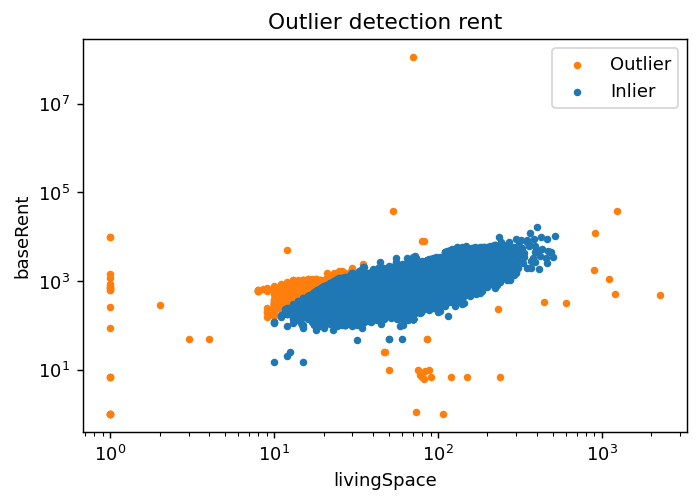

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots()
rent_outlier_df.plot.scatter(
    x="livingSpace",
    y="baseRent",
    loglog=True,
    title="Outlier detection rent",
    color="C1",
    label="Outlier",
    s=10,
    ax=ax,
)
rent_inlier_df.plot.scatter(
    x="livingSpace", y="baseRent", color="C0", label="Inlier", s=10, ax=ax
)
fig.savefig("rent_outlier.pdf")

### 2.2) Apartments for sale

In [13]:
start = timer()

sale_outlier = EllipticEnvelope(
    contamination=contamination, random_state=42
).fit_predict(X_sale)
sale_inlier_df = sale_select_df[(sale_outlier == 1)]
sale_outlier_df = sale_select_df[(sale_outlier == -1)]

end = timer()
print(f"Elapsed time: {np.round(end - start,2)}s")

Elapsed time: 8.19s


<IPython.core.display.Javascript object>

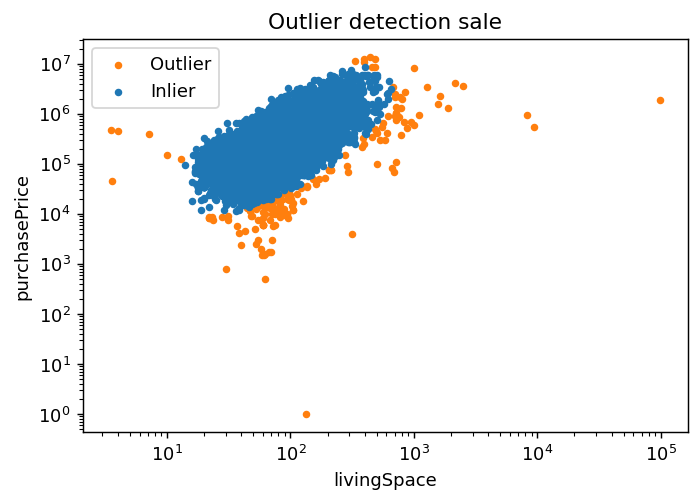

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots()
sale_outlier_df.plot.scatter(
    x="livingSpace",
    y="purchasePrice",
    loglog=True,
    title="Outlier detection sale",
    color="C1",
    label="Outlier",
    s=10,
    ax=ax,
)
sale_inlier_df.plot.scatter(
    x="livingSpace", y="purchasePrice", color="C0", label="Inlier", s=10, ax=ax
)

## 3) Results

### 3.1) Best ROI nationally

#### Outlier:

In [15]:
sale_outlier_df.sort_values("yearly_ROI", ascending=False).head(10)

,yearly_ROI,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
30460,13875.43,7.52e-03,1.00e+00,133.00,3.0,27793,8.69,Oldenburg_Kreis,https://www.immobilienscout24.de/expose/116978696
31308,10.44,7.98e+00,5.00e+02,62.66,3.0,31698,6.94,Schaumburg_Kreis,https://www.immobilienscout24.de/expose/116556571
32917,4.73,1.26e+01,4.00e+03,318.00,10.0,4639,4.96,Altenburger_Land_Kreis,https://www.immobilienscout24.de/expose/115369915
36060,3.89,2.67e+01,8.00e+02,30.00,1.0,49152,8.64,Osnabrück_Kreis,https://www.immobilienscout24.de/expose/105011041
36074,3.21,1.87e+01,1.85e+06,99015.00,1.0,6385,5.00,Anhalt_Bitterfeld_Kreis,https://www.immobilienscout24.de/expose/104440723
22058,2.87,4.24e+01,3.00e+03,70.76,3.0,17489,10.16,Greifswald,https://www.immobilienscout24.de/expose/120144748
25562,2.50,5.70e+01,5.35e+05,9377.00,4.0,90766,11.87,Fürth,https://www.immobilienscout24.de/expose/119423700
22074,2.42,2.46e+01,1.50e+03,61.00,2.0,4639,4.96,Altenburger_Land_Kreis,https://www.immobilienscout24.de/expose/120144160
22072,2.42,2.46e+01,1.70e+03,69.00,2.0,4639,4.96,Altenburger_Land_Kreis,https://www.immobilienscout24.de/expose/120144152
22073,2.35,2.54e+01,1.70e+03,67.00,2.0,4639,4.96,Altenburger_Land_Kreis,https://www.immobilienscout24.de/expose/120144153


<IPython.core.display.Javascript object>

#### Inlier:

In [16]:
sale_inlier_df.sort_values("yearly_ROI", ascending=False).head(10)

,yearly_ROI,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
29261,0.51,1242.75,45000.0,36.21,1.0,77740,52.42,Ortenaukreis,https://www.immobilienscout24.de/expose/117749320
35538,0.47,1345.46,145000.0,107.77,4.0,77740,52.42,Ortenaukreis,https://www.immobilienscout24.de/expose/110436432
6495,0.40,323.53,33000.0,102.00,4.0,38315,10.80,Wolfenbüttel_Kreis,https://www.immobilienscout24.de/expose/120144341
12261,0.34,1864.04,170000.0,91.20,3.0,77740,52.42,Ortenaukreis,https://www.immobilienscout24.de/expose/111534392
36346,0.32,533.63,119000.0,223.00,6.0,90429,14.44,Nürnberg,https://www.immobilienscout24.de/expose/91497244
6498,0.29,335.07,36000.0,107.44,4.0,50127,8.00,Rhein_Erft_Kreis,https://www.immobilienscout24.de/expose/120144593
6428,0.27,395.01,19000.0,48.10,2.0,33611,8.84,Bielefeld,https://www.immobilienscout24.de/expose/120144844
6450,0.24,289.86,20000.0,69.00,3.0,27729,5.75,Osterholz_Kreis,https://www.immobilienscout24.de/expose/120144450
32280,0.23,575.00,69000.0,120.00,6.0,38315,10.80,Wolfenbüttel_Kreis,https://www.immobilienscout24.de/expose/115749410
6432,0.22,338.00,16900.0,50.00,2.0,47198,6.30,Duisburg,https://www.immobilienscout24.de/expose/120144313


<IPython.core.display.Javascript object>

### 3.2) Apartments by region

#### regions overview:

In [17]:
min_num = 5
combined_filt_ord = "median_yearly_ROI"

combined_filt = (combined_df["num_rent"] > min_num) & (
    combined_df["num_sale"] > min_num
)
combined_df[combined_filt].sort_values(combined_filt_ord, ascending=False)

,median_rent_m2,num_rent,median_price_m2,num_sale,median_yearly_ROI
zipCode,,,,,
4639,4.96,8,25.37,7.0,2.35
47169,6.16,58,142.25,22.0,0.52
17139,5.11,19,391.11,6.0,0.16
47229,6.57,30,570.55,8.0,0.14
8412,4.89,249,439.31,21.0,0.13
...,...,...,...,...,...
80333,28.77,38,20115.54,24.0,0.02
83700,17.24,10,12895.17,28.0,0.02
4328,6.50,41,4881.28,42.0,0.02


<IPython.core.display.Javascript object>

#### pick regions to further inspect:

In [18]:
regions = [72074]
combined_df.loc[regions]

,median_rent_m2,num_rent,median_price_m2,num_sale,median_yearly_ROI
zipCode,,,,,
72074,13.82,8,4954.84,3.0,0.03


<IPython.core.display.Javascript object>

### 3.3) Apartments for rent

In [19]:
rent_filt_col = "zipCode"
rent_filt_arg = regions
rent_ord = "rent_m2"

rent_filt = rent_select_df[rent_filt_col].isin(rent_filt_arg)
rent_select_df[rent_filt].sort_values(rent_ord).head(20)

,rent_m2,baseRent,livingSpace,noRooms,zipCode,regio2,link
36911,9.51,371.0,39.0,1.0,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120137026
63296,10.00,1500.0,150.0,5.0,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/118496278
36992,11.00,924.0,84.0,3.0,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120135517
98430,13.64,300.0,22.0,1.0,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/65446426
12624,14.00,1470.0,105.0,3.0,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/117551317
976,14.80,1850.0,125.0,4.0,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/119837191
34821,15.57,475.0,30.5,1.5,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/94758279
37949,21.30,980.0,46.0,2.0,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120098486


<IPython.core.display.Javascript object>

### 3.4) Apartments for sale

In [20]:
sale_filt_col = "zipCode"
sale_filt_arg = regions
sale_ord = "yearly_ROI"

sale_filt = sale_select_df[sale_filt_col].isin(sale_filt_arg)
sale_select_df[sale_filt].sort_values(sale_ord, ascending=False)

,yearly_ROI,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
11735,0.04,4736.84,360000.0,76.0,3.0,72074,13.82,Tübingen_Kreis,https://www.immobilienscout24.de/expose/116571440
17229,0.03,4954.84,768000.0,155.0,4.0,72074,13.82,Tübingen_Kreis,https://www.immobilienscout24.de/expose/117501062
20158,0.03,5572.73,613000.0,110.0,4.5,72074,13.82,Tübingen_Kreis,https://www.immobilienscout24.de/expose/117071241


<IPython.core.display.Javascript object>